Tutorial: Combine simulations - Born approximation
=================

This tutorial demonstrates how to use the tool `combine_simulations` to study near-field coupling effects.

setup single silicon cube simulation
-------------------

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from pyGDM2 import core
from pyGDM2 import propagators
from pyGDM2 import fields
from pyGDM2 import materials
from pyGDM2 import linear

from pyGDM2 import structures
from pyGDM2 import tools
from pyGDM2 import visu


# =============================================================================
# some global parameters
# =============================================================================
solver_method = 'cupy'      # on CUDA-GPU
#solver_method = 'scipyinv'


## simulation environment
n3 = 1.0   # cladding layer
n2 = 1.0   # environment
n1 = 1.45  # substrate
dyads = propagators.DyadsQuasistatic123(n1, n2, n3)


# =============================================================================
# set up dielectric cube structure
# =============================================================================
## size of blocks
mesh = 'cube'
step = 20     # in nm

## generate two different size cuboids
geo = structures.rect_wire(step, L=5, H=5, W=5, mesh=mesh)
material = materials.silicon()
struct_single = structures.struct(step, geo, material)

print('N dipoles = {}'.format(len(geo)))


# =============================================================================
# illumination: y-polarized, normal incidence plane wave, single wavelength
# =============================================================================
field_generator = fields.plane_wave
wavelengths = [600]  # nm
field_kwargs = dict(inc_angle=0, E_s=1, E_p=0)  # 0 deg: incidence from below, s-polar.: Y

efield = fields.efield(field_generator, wavelengths=wavelengths, kwargs=field_kwargs)


# =============================================================================
# single cube simulation object
# =============================================================================
sim_single = core.simulation(struct=struct_single, efield=efield, dyads=dyads)

structure initialization - automatic mesh detection: cube
structure initialization - consistency check: 125/125 dipoles valid
N dipoles = 125


setup array of simulations
--------------------------------------

Now we create a planar array of 5x5 silicon nano-cubes, the center-to-center distance is 150nm (gaps of 50nm). This should be sufficiently close to induce significant near-field interaction.

Run isolated simulations...


/home/hans/.local/lib/python3.8/site-packages/numba/core/dispatcher.py:237: UserWarning: Numba extension module 'numba_scipy' failed to load due to 'ValueError(No function '__pyx_fuse_0pdtr' found in __pyx_capi__ of 'scipy.special.cython_special')'.
  entrypoints.init_all()


timing for wl=600.00nm - setup: EE 2777.3ms, HE 227.5ms, inv.: 563.1ms, repropa.: 831.7ms (1 field configs), tot: 4399.9ms
timing for wl=600.00nm - setup: EE 38.5ms, HE 13.5ms, inv.: 1.0ms, repropa.: 13.7ms (1 field configs), tot: 67.4ms
timing for wl=600.00nm - setup: EE 38.2ms, HE 13.3ms, inv.: 1.1ms, repropa.: 13.8ms (1 field configs), tot: 66.6ms
timing for wl=600.00nm - setup: EE 37.8ms, HE 12.0ms, inv.: 1.0ms, repropa.: 13.5ms (1 field configs), tot: 64.5ms
timing for wl=600.00nm - setup: EE 39.7ms, HE 13.3ms, inv.: 1.4ms, repropa.: 14.2ms (1 field configs), tot: 68.8ms
timing for wl=600.00nm - setup: EE 39.2ms, HE 13.5ms, inv.: 1.0ms, repropa.: 13.7ms (1 field configs), tot: 67.5ms
timing for wl=600.00nm - setup: EE 37.7ms, HE 13.9ms, inv.: 1.1ms, repropa.: 17.6ms (1 field configs), tot: 70.5ms
timing for wl=600.00nm - setup: EE 38.6ms, HE 13.8ms, inv.: 1.0ms, repropa.: 13.8ms (1 field configs), tot: 67.5ms
timing for wl=600.00nm - setup: EE 37.9ms, HE 21.1ms, inv.: 2.1ms, repro

/home/hans/.local/lib/python3.8/site-packages/pyGDM2/visu.py:49: UserWarning: 3D data. Falling back to XY projection...
  warnings.warn("3D data. Falling back to XY projection...")


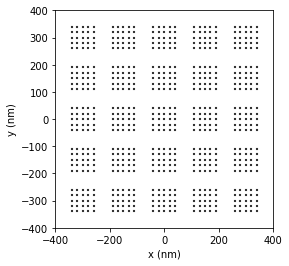

Run combined simulation...
timing for wl=600.00nm - setup: EE 16310.4ms, HE 3740.0ms, inv.: 1191.4ms, repropa.: 755.8ms (1 field configs), tot: 22104.7ms


1

In [2]:
## create copies of simulation with shifted structure
print("Run isolated simulations...")
sim_list = []
for ix in np.arange(-2,3):
    for iy in np.arange(-2,3):
        ## copy and shift simulation
        _sim = sim_single.copy()
        _sim = structures.shift(_sim, [ix*150, iy*150, 0])
        
        ## run sim
        _sim.scatter(method=solver_method, calc_H=1)
        
        ## add to list
        sim_list.append(_sim)


## combine simulations. This also combines the individually simulated fields
## --> the combined simulation corresponds to the Born approximation 
## (= no optical interactions between scatterers)
sim_array_born = tools.combine_simulations(sim_list)
visu.structure(sim_array_born, scale=0.45)


## we copy the combined sim again and run `scatter` to get the full optical response
print("Run combined simulation...")
sim_array = sim_array_born.copy()
sim_array.scatter(method=solver_method, calc_H=1)

Plot the real part of the E-field vectors
--------------------------------

Near-field plots reveal a significant impact of the optical interactions between the nano-cubes

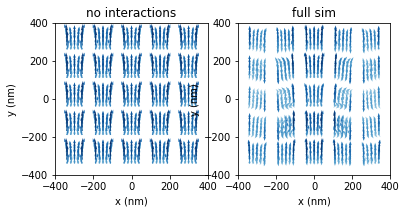

In [3]:
#%% plot field vectors (real part)
plt.subplot(121)
plt.title("no interactions")
visu.vectorfield_by_fieldindex(sim_array_born, field_index=0, show=0)

plt.subplot(122)
plt.title("full sim")
visu.vectorfield_by_fieldindex(sim_array, field_index=0, show=0)

plt.show()

Plot near-field intensity maps 50nm above
--------------------------------------

Near-field plots reveal a significant impact of the optical interactions between the nano-cubes

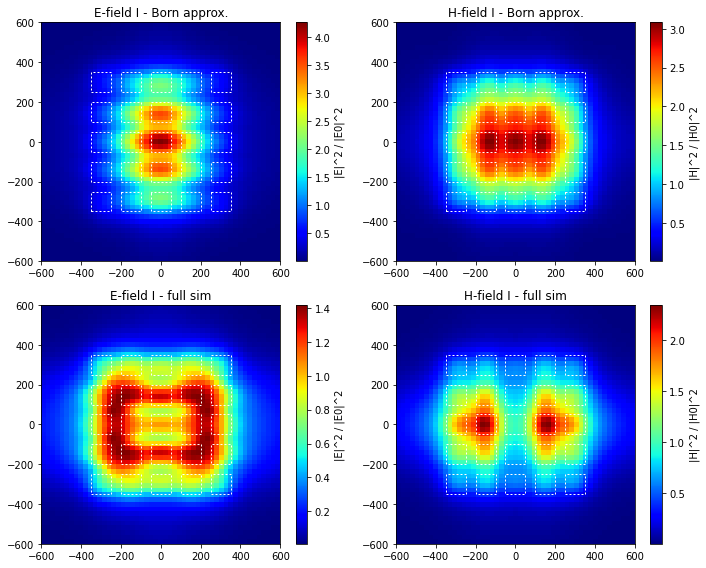

In [4]:
## nearfield map
r_probe = tools.generate_NF_map(-600, 600, 51, -600, 600, 51, Z0=150)

## total and scattered fields
Et_b, Es_b, Bt_b, Bs_b = linear.nearfield(sim_array_born, field_index=0, r_probe=r_probe)
Et, Es, Bt, Bs = linear.nearfield(sim_array, field_index=0, r_probe=r_probe)


## plot
plt.figure(figsize=(10,8))

plt.subplot(221)
visu.structure_contour(sim_array_born, color='w', dashes=[2,2], show=0)
im = visu.vectorfield_color(Et_b, tit='E-field I - Born approx.', cmap='jet', show=0)
plt.colorbar(im, label='|E|^2 / |E0|^2')

plt.subplot(222)
visu.structure_contour(sim_array_born, color='w', dashes=[2,2], show=0)
im = visu.vectorfield_color(Bt_b, tit='H-field I - Born approx.', cmap='jet', show=0)
plt.colorbar(im, label='|H|^2 / |H0|^2')


plt.subplot(223)
visu.structure_contour(sim_array, color='w', dashes=[2,2], show=0)
im = visu.vectorfield_color(Et, tit='E-field I - full sim', cmap='jet', show=0)
plt.colorbar(im, label='|E|^2 / |E0|^2')

plt.subplot(224)
visu.structure_contour(sim_array, color='w', dashes=[2,2], show=0)
im = visu.vectorfield_color(Bt, tit='H-field I - full sim', cmap='jet', show=0)
plt.colorbar(im, label='|H|^2 / |H0|^2')


plt.tight_layout()
plt.show()